In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

### Load the ground-truth and evaluate the methods

In [2]:
from intestine_info import load_processed_enterocyte_data, load_original_entero_zonation
from intestine_info import get_intestine_rna_lm_genes
from io_utils import load_all_pipeline_results, load_single_result
from io_utils import save_data_to_file
from plot_utils import plot_corr_mtx
from scrna_utils import get_gene_df
from general_utils import rank_and_bin

res_dir = "/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719"
zone_vals = load_original_entero_zonation(just_vals=True)
obs_df, var_df, mtx = load_processed_enterocyte_data(res_dir)
RDIR = os.path.join(res_dir, "entero_data", "results")
method = 'graph'
mtype = 'vanilla'
ddir = os.path.join(res_dir, 'entero_data', 'results', '{}_{}'.format(method, mtype))
os.makedirs(ddir, exist_ok=True)
fns = {
    'result': os.path.join(ddir, 'method_result.pkl'),
    'coeff_mtx': os.path.join(ddir, 'coeff_matrix.npy'),
    'embed_dict': os.path.join(ddir, 'embed_dict.pkl'),
    'gene_clust_df': os.path.join(ddir, 'gene_clust_df.csv')
}

[feat_viz INFO] {'Crypt': 0, 'V1': 1, 'V2': 2, 'V3': 3, 'V4': 4, 'V5': 5, 'V6': 6}


In [3]:
result = load_single_result(RDIR, method, mtype)
n_rej = len(result['rejections'])
n_genes = len(result['p_vals'])
print('Number of rejections: {} ({:.2f}%)'.format(n_rej, n_rej / n_genes * 100))
save_data_to_file(result, fns['result'], 'pkl')

Number of rejections: 6892 (71.38%)


# Fit the curve on all genes

In [76]:
from spline_utils import setup_basis, spline_fit
from general_utils import rank_and_bin, norm_mtx
# get the variable group ids
mtx = norm_mtx(mtx)
lam = result["lam_update"]
base_args = setup_basis(lam, n_knots=10)
print(base_args)
p_fun, c_mtx = spline_fit(lam, mtx, base_args)
save_data_to_file(c_mtx, fns['coeff_mtx'], 'npy')

cr(x, knots=(-0.024, -0.015, -0.006, 0.003, 0.012, 0.021, 0.031, 0.04, 0.049, 0.058))
Fitted 1000 parameters
Fitted 2000 parameters
Fitted 3000 parameters
Fitted 4000 parameters
Fitted 5000 parameters
Fitted 6000 parameters
Fitted 7000 parameters
Fitted 8000 parameters
Fitted 9000 parameters


In [77]:
from main_methods import refit_curves
print(c_mtx.shape)
x_vals, fit_mtx = refit_curves(c_mtx, base_args, lam)

[feat_viz INFO] Fitted points stored in (50, 9656)


(9656, 13)


# Remove low variance genes 

In [78]:
var_df.head()

,gene_ids,n_cells,mean,std,npc
0,Mrpl15,530,0.386412,0.530710,530
1,Lypla1,1045,0.999767,0.698513,1045
2,Tcea1,367,0.225788,0.401705,367
3,Atp6v1h,171,0.101006,0.292252,171
4,Rb1cc1,340,0.220587,0.425791,340


In [79]:
from intestine_info import load_gene_set_clusters
from plot_utils import plot_venn
# use the cutoff to select genes to further cluster
def select_variable_genes(result, var_df, cut_off = 0.5):
    sel = var_df['std'] > cut_off
    high_var_idx = var_df.loc[sel].index.values
    cor_sel_idx = result['rejections']
    int_size = set(high_var_idx).intersection(set(cor_sel_idx))
    print('{} out of {} are spatial varying'.format(len(int_size), len(high_var_idx)))
    kmtx, kdf = load_gene_set_clusters(var_df)
    gset = {}
    gset['moor_sel'] = set(kdf.index)
    gset['high_var'] = set(var_df.loc[sel]['gene_ids'])
    gset['space_var'] = set(var_df.loc[result['rejections']]['gene_ids'])
    use_df = var_df.loc[sel]
    use_df = use_df.loc[use_df.index.isin(result['rejections'])]
    ndf = kdf.loc[kdf['orig_idx'].isin(use_df.index)]
    vals = pd.Series(-1*np.ones(use_df.shape[0]), index=use_df.index).astype(int)
    vals[ndf['orig_idx']] = ndf['clust_idx']
    use_df['moor_clust'] = vals
    return use_df, gset
use_df, gset =  select_variable_genes(result, var_df)
print(use_df.shape)
use_df.head()

1913 out of 1981 are spatial varying
(1913, 6)


,gene_ids,n_cells,mean,std,npc,moor_clust
0,Mrpl15,530,0.386412,0.530710,530,1
1,Lypla1,1045,0.999767,0.698513,1045,3
14,Arfgef1,732,0.559252,0.594950,732,3
16,Tram1,707,0.536192,0.579412,707,1
20,Rpl7,1009,1.524548,1.203265,1009,4


Retaining genes: 1913


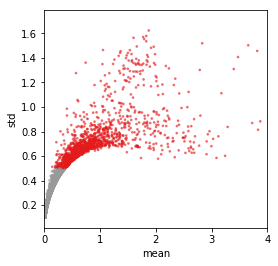

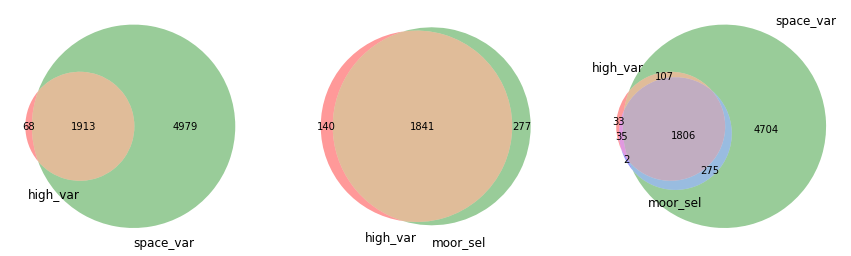

In [80]:
sel_or_not = (var_df.index.isin(use_df.index))
print('Retaining genes: {}'.format(np.sum(sel_or_not)))
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.scatter(var_df['mean'], var_df['std'], c=sel_or_not*-1, 
           s=3, cmap='Set1', alpha =0.5)
ax.set_xlabel('mean')
ax.set_ylabel('std')
ax.set_xlim(0, 4)
plt.show()
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_venn(gset, ['high_var', 'space_var'], ax=axes[0])
plot_venn(gset, ['high_var', 'moor_sel'], ax=axes[1])
plot_venn(gset, ['high_var', 'space_var', 'moor_sel'], ax=axes[2])
plt.show()

# Run the gene clustering pipeline

In [81]:
# our pipeline
import umap
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans

uobj = umap.UMAP(random_state=10101)
u_mtx = c_mtx[use_df.index, :]
print("input dimension: {}".format(u_mtx.shape))
embedding = uobj.fit_transform(u_mtx)

input dimension: (1913, 13)


In [105]:
def graph_spectrum(A, n_eigs=20):
    L = csgraph.laplacian(A)
    eigenvalues, eigenvectors = eigsh(L, which='SM', k=n_eigs)
    return eigenvalues, eigenvectors

def graph_clustering(eigenvectors, k_vals):   
#     k_vals = [4, 5, 6, 7, 8, 9, 10, 11, 12]
#     X = eigenvectors[:, 1:]
    df = pd.DataFrame()
    for n_clust in k_vals:
        X = eigenvectors[:, 1:(n_clust+1)]
        kmeans = KMeans(n_clusters=n_clust, random_state=0).fit(X)
        labs = kmeans.labels_
        name = 'k_{}'.format(n_clust)
        df[name] = labs
    return df
evals, evecs = graph_spectrum(uobj.graph_)
optimal_kvals = np.argsort(np.diff(evals))[::-1] + 1
print(optimal_kvals)
k_vals = [5, 6, 7, 8, 9, 10] # + [14, 15, 16, 17, 18]
kids = ['k_{}'.format(k) for k in k_vals] 
clust_df = graph_clustering(evecs, k_vals)
# merge
mdf = use_df.reset_index().rename(columns={'index': 'orig_idx'})
mdf = mdf.join(clust_df)
mdf = mdf.set_index('gene_ids')
mdf['umap 1'] = embedding[:, 0]
mdf['umap 2'] = embedding[:, 1]
kmtx, kdf = load_gene_set_clusters(var_df)
int_df = kdf.join(mdf.drop('orig_idx', axis=1), how='inner')
print(int_df.shape)
int_df.head()
assert np.array_equal(int_df['clust_idx'], int_df['moor_clust']), 'moor clust mismatch'
display(int_df.head())

[ 8 16 14 10 12  3 18  6 19  7  2  1  5 13  9 11 17 15  4]
(1806, 17)


,indin,clust_idx,curr_idx,orig_idx,n_cells,mean,std,npc,moor_clust,k_5,k_6,k_7,k_8,k_9,k_10,umap 1,umap 2
Mrpl15,8,1,0,0,530,0.386412,0.530710,530,1,0,4,1,0,1,3,3.426974,1.825219
Lypla1,9,3,1,1,1045,0.999767,0.698513,1045,3,1,1,0,1,4,2,-1.018863,2.132562
Arfgef1,40,3,2,14,732,0.559252,0.594950,732,3,0,4,1,0,1,1,0.365097,0.766512
Tram1,52,1,3,16,707,0.536192,0.579412,707,1,0,4,1,0,1,1,1.396103,0.118592
Rpl7,63,4,4,20,1009,1.524548,1.203265,1009,4,4,3,4,2,6,4,7.547403,2.777340


In [101]:
# compute embedding from moor zonation
from main_methods import compute_embedding
moor_embed = compute_embedding(kmtx[int_df['curr_idx'], :])

input dimension: (1806, 7)


In [104]:
clust_df.head()

,k_5,k_6,k_7,k_8,k_9,k_10
0,0,4,1,0,1,3
1,1,1,0,1,4,2
2,0,4,1,0,1,1
3,0,4,1,0,1,1
4,4,3,4,2,6,4


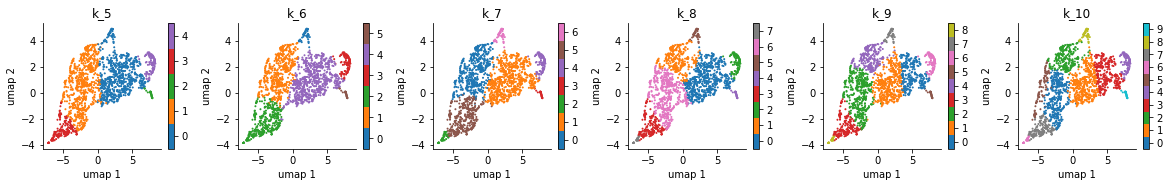

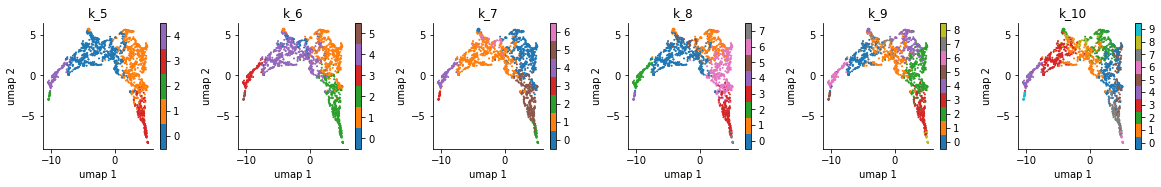

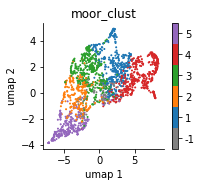

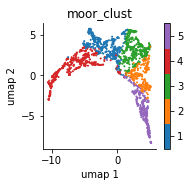

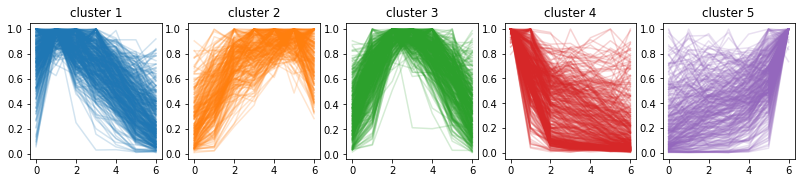

In [107]:
from plot_utils import plot_multiple_scatter_discrete
cmp_dict = {
    'moor': {
        'x': np.arange(kmtx.shape[1]),
        'mtx': kmtx.T,
        'idx': 'curr_idx',
    },
    'ours': {
        'x': -x_vals,
        'mtx': fit_mtx,
        'idx': 'orig_idx',
    }
}
from plot_utils import plot_multi_curves, get_sim_color_map
def plot_cluster_curves(ddf, col, dat):
    cids = np.unique(ddf[col])
    lut = get_sim_color_map(ddf[col], palette='tab10')
    figsize = (2.9*len(cids)-0.2*(len(cids)-1),2.5)
    fig, axes = plt.subplots(1, len(cids), figsize=figsize)
    for i, cid in enumerate(cids):
        sel = ddf[col] == cid
        idx = ddf.loc[sel][dat['idx']]
        mat = dat['mtx'][:, idx]
        x = dat['x']
        ax = axes[i]
        plot_multi_curves(ax, x, mat, alpha=0.2, color=lut[cid])
        ax.set_title('cluster {}'.format(cid))
    plt.show()
    
plot_multiple_scatter_discrete(embedding, clust_df)
plot_multiple_scatter_discrete(moor_embed, int_df[kids])
plot_multiple_scatter_discrete(embedding, use_df[['moor_clust']])
plot_multiple_scatter_discrete(moor_embed, int_df[['moor_clust']])

plot_cluster_curves(int_df, 'moor_clust', cmp_dict['moor'])

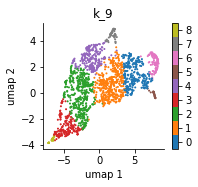

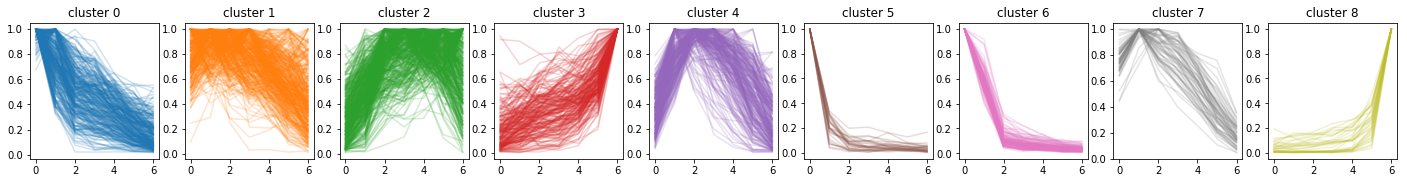

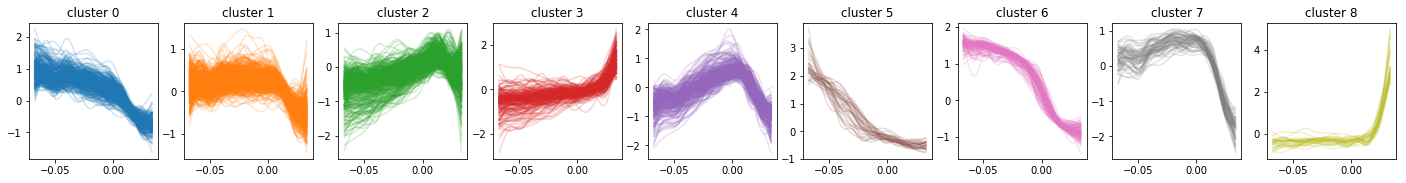

In [122]:
use_k = 'k_9'
plot_multiple_scatter_discrete(embedding, clust_df[[use_k]])
plot_cluster_curves(int_df, use_k, cmp_dict['moor'])
plot_cluster_curves(int_df, use_k, cmp_dict['ours'])

In [121]:
for g in sorted(int_df.loc[int_df[use_k] == 0].index):
    print(g)

0610012G03Rik
1110001J03Rik
1110008F13Rik
1700020I14Rik
1810037I17Rik
1810043H04Rik
2310036O22Rik
2410015M20Rik
2610507B11Rik
2610528J11Rik
2700060E02Rik
AY036118
Abracl
Acat1
Adipor1
Ago2
Akr1c13
Anapc13
Ankrd11
Ap1ar
Ap1s1
Ap2m1
Ap2s1
Arfgef1
Arid1a
Arl6ip1
Arpc1a
Arpc1b
Arpc3
Arpc4
Arpc5
Arpp19
Atp2a2
Atp5g2
Atp6v1f
Atp6v1g1
Atxn7l3b
Aup1
Aurkaip1
B4galnt1
BC031181
Bag1
Baiap2l2
Banf1
Bcap31
Bola2
Bola3
Bri3
Brk1
Btf3
Bzw1
C1d
Calm2
Calm3
Calr
Camk2d
Canx
Caprin1
Capza1
Carhsp1
Ccdc12
Ccdc124
Cct4
Cd164
Cd2ap
Cd47
Cd81
Cdk2ap2
Cdv3
Cdx1
Cdx2
Celf1
Cenpv
Cfl1
Cggbp1
Chchd1
Chchd2
Chchd3
Churc1
Cisd2
Clint1
Clta
Cnbp
Cnih1
Cnih4
Cnpy2
Coa3
Coa5
Comt
Cox14
Cox19
Cox20
Cox7a2l
Cps1
Csde1
Csnk2a1
Csnk2b
Cst3
Cstb
Ctbp1
Ctnnbip1
Ctsb
Cuta
D8Ertd738e
Dad1
Dag1
Ddb1
Ddi2
Dera
Dhrs4
Dmbt1
Dnaja1
Dnaja2
Dnajb6
Dnajc19
Dph3
Dpm3
Dynll1
Dynll2
Dynlrb1
Eef1d
Eef2
Efr3a
Eif2s2
Eif3a
Eif3k
Eif4a1
Eif4a2
Eif4b
Eif4e2
Eif4g1
Eif4g2
Eif4h
Eif5
Elof1
Emc6
Emg1
Eny2
Epn1
Ergic3
Esd
Etfb
Fam104a
Fam120a

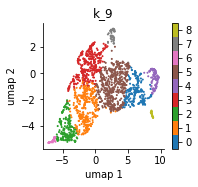

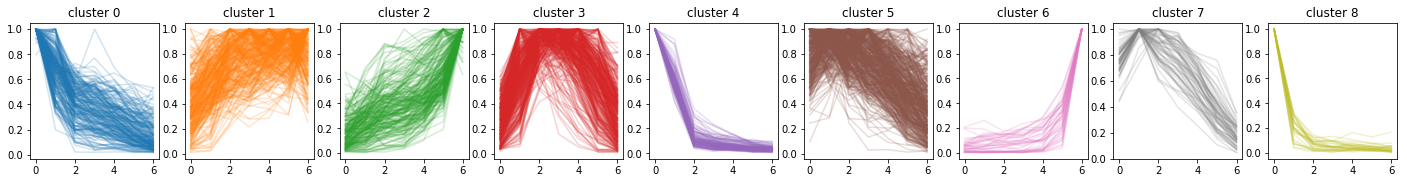

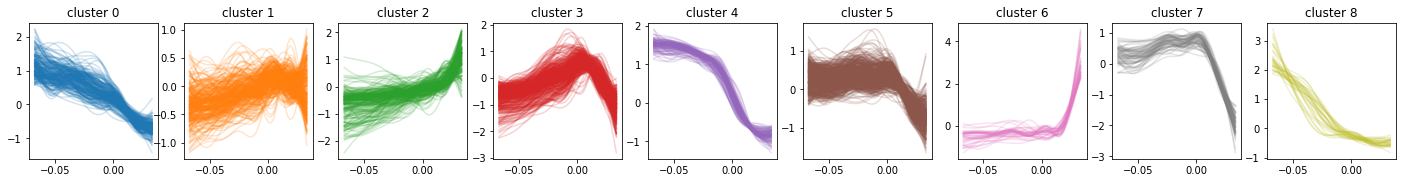

In [74]:
use_k = 'k_9'
plot_multiple_scatter_discrete(embedding, clust_df[[use_k]])
plot_cluster_curves(int_df, use_k, cmp_dict['moor'])
plot_cluster_curves(int_df, use_k, cmp_dict['ours'])

# Compute other embeddings and save to file

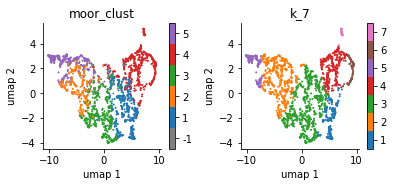

,moor_clust,k_7,orig_idx,umap 1,umap 2
gene_ids,,,,,
Mrpl15,1,4,0,4.926238,-0.184812
Lypla1,3,3,1,0.104795,-2.111069
Arfgef1,3,3,14,0.563742,-0.279991
Tram1,1,3,16,2.554482,0.759715
Rpl7,4,6,20,9.137628,1.204674


In [14]:
# let us reassign-values
use_k = 'k_7'
cmp = mdf[['moor_clust', use_k, 'gene_ids', 'orig_idx']].copy()
# mapping = {5: 1, 2: 2, 3: 3, 1: 4, 4: 5, -1: -1}
# cmp['moor_clust'] = cmp['moor_clust'].map(mapping)
mapping = {1: 1, 3: 2, 0: 3, 2: 4, 5: 5, 6: 6, 4:7}
cmp[use_k] = cmp[use_k].map(mapping)
cmp = cmp.set_index('gene_ids')
cmp['umap 1'] = embedding[:, 0]
cmp['umap 2'] = embedding[:, 1]
plot_multiple_scatter_discrete(cmp[['umap 1', 'umap 2']], 
                               cmp[['moor_clust', use_k]])
cmp.head()

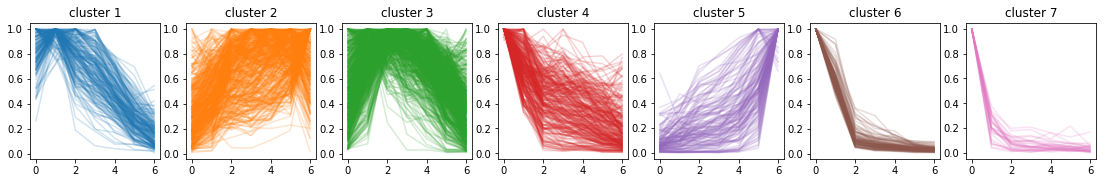

In [39]:
from plot_utils import plot_multi_curves, get_sim_color_map
def plot_cluster_curves(ddf, col, dat):
    cids = np.unique(ddf[col])

    lut = get_sim_color_map(ddf[col], palette='tab10')
    figsize = (2.9*len(cids)-0.2*(len(cids)-1),2.5)
    fig, axes = plt.subplots(1, len(cids), figsize=figsize)
    for i, cid in enumerate(cids):
        sel = ddf[col] == cid
        idx = ddf.loc[sel][dat['idx']]
        mat = dat['mtx'][:, idx]
        x = dat['x']
        ax = axes[i]
        plot_multi_curves(ax, x, mat, alpha=0.2, color=lut[cid])
        ax.set_title('cluster {}'.format(cid))
    plt.show()
    
plot_cluster_curves(int_df, use_k, cmp_dict['moor'])

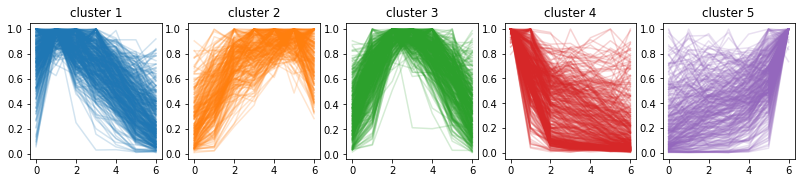

In [40]:
plot_cluster_curves(int_df, 'moor_clust', cmp_dict['moor'])

In [11]:
from main_methods import compute_all_embeddings
from intestine_info import load_gene_set_clusters
from main_methods import compute_embedding
from general_utils import norm_mtx
embed_dict = compute_all_embeddings(result, c_mtx, mtx)
naive = compute_embedding(mtx[:, use_df.index].T)
naive['id'] = use_df.index
ours = pd.DataFrame(embedding, columns=['umap 1', 'umap 2'])
ours['id'] = use_df.index
print(naive.head())
print(ours.head())
embed_dict['trim_coefficient'] = embedding
embed_dict['trim_expression'] = naive
save_data_to_file(embed_dict, fns['embed_dict'], 'pkl')

Computing embedding for: all_coefficient
input dimension: (9656, 5)
Computing embedding for: all_expression
input dimension: (9656, 1383)
Computing embedding for: rejected_coefficient
input dimension: (6892, 5)
Computing embedding for: rejected_expression
input dimension: (6892, 1383)
input dimension: (1913, 1383)
     umap 1    umap 2  id
0  6.718366 -0.274741   0
1  1.275690 -1.400125   1
2  3.020895 -1.508550  14
3  6.180366 -1.110975  16
4  7.444591 -0.965993  20
     umap 1    umap 2  id
0  4.926238 -0.184812   0
1  0.104795 -2.111069   1
2  0.563742 -0.279991  14
3  2.554482  0.759715  16
4  9.137628  1.204674  20


In [12]:
clust_df.head()

,k_4,k_5,k_6,k_7,k_8
0,1,0,5,2,3
1,1,1,1,0,3
2,1,0,1,0,3
3,1,0,1,0,3
4,3,3,4,6,7


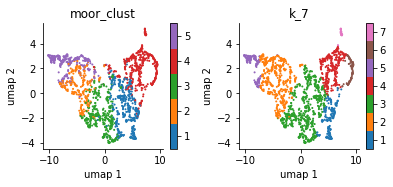

In [16]:
plot_multiple_scatter_discrete(int_df[['umap 1', 'umap 2']], 
                               int_df[['moor_clust', use_k]])

# Optional look at the gap statistics

Optimal K = 19


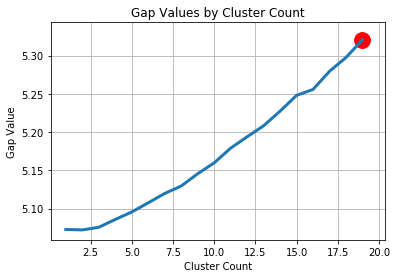

In [40]:
from main_methods import optimalK
k, gapdf = optimalK(evecs[:, 1:])
print('Optimal K = {}'.format(k))
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

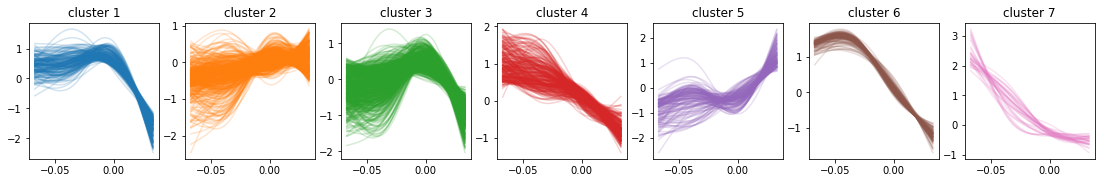

In [45]:
plot_cluster_curves(int_df, use_k, cmp_dict['ours'])

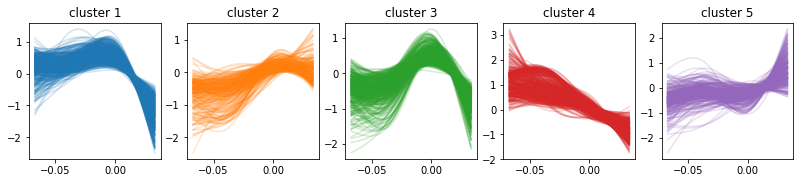

In [46]:
plot_cluster_curves(int_df, 'moor_clust', cmp_dict['ours'])

In [ ]:
# for grp in range(1+max(np.unique(var_df.nn_grp))):
for grp in np.unique(var_df.nn_grp):
    ids = var_df.loc[var_df['nn_grp']==grp]['var_id']
    fig, ax = plt.subplots(1, 1, figsize=(2,2))
    # sub_sample:
    np.random.seed(10)
    ids = np.random.choice(ids, size=30)
    plot_multi_curves(ax, x_vals, fit_mtx[:, ids],
                      alpha=0.5, color=lut[grp])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_ylim(-1.1,1.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    

In [78]:
new_df = kdf.join(cmp, on='orig_idx', how='inner', lsuffix='_c')
print(new_df.shape)
new_df.head()

(377, 8)


,indin,clust_idx,curr_idx,orig_idx_c,moor_clust,k_7,gene_ids,orig_idx
gene_name,,,,,,,,
Mrpl15,8,1,0,0,1,4,Mrpl15,0
Lypla1,9,3,1,1,3,3,Lypla1,1
Arfgef1,40,3,2,14,5,2,Slc9a2,72
Tram1,52,1,3,16,5,2,Stk17b,97
Rpl7,63,4,4,20,4,4,Bzw1,110


,indin,clust_idx,curr_idx,orig_idxc,moor_clust,k_7,gene_ids,orig_idx
gene_name,,,,,,,,
Mrpl15,8,1,0,0,1,4,Mrpl15,0
Lypla1,9,3,1,1,3,3,Lypla1,1
Arfgef1,40,3,2,14,5,2,Slc9a2,72
Tram1,52,1,3,16,5,2,Stk17b,97
Rpl7,63,4,4,20,4,4,Bzw1,110


In [ ]:
# select the rows from the k

In [56]:
comps = [(1,1), (4, 6), (4, 7), (3,3), (2, 2), (5, 5)] # 
for comp in comps:
    for i in range(len(comp)):
        if i == 0:
            col = 'moor_clust'
        else:
            col = use_k
        gdf = cmp.loc[cmp[col]==comp[i]]
        print('{} : {}'.format(col, gdf.shape[0]))
        gset = set(gdf['gene_ids'])
        for g in gset:
            print(g)
        print('\n\n')
    break

moor_clust : 404
Ndufv2
Ndufs6
Ubxn1
Canx
Rab10
Lad1
Ndufs4
Lrrc59
Scand1
H2afj
Ndufa10
Ppdpf
Dnaja1
Sepw1
Ogt
Jtb
Ucp2
Cnih1
Gls
Tram1
Mettl9
Mrps21
Dynll2
Ociad2
Tmed10
Tmed7
Tmem14c
Cox6a1
Mpc1
2610528J11Rik
Uqcr11
Sod2
Rap1a
Atp5b
Cd81
Nfe2l2
Aldoa
Fam96b
Ndufb7
Immt
Tspan15
Atp5j
Arpc5
Ube2m
Znhit1
Tomm70a
Mrpl15
Cd164
Nlrp6
Higd2a
Chchd10
Vdac3
Lamtor4
Atp5h
Adipor1
Me2
Ndufa9
Pomp
Gsta1
Cnih4
Bsg
Txnrd1
Coa5
D8Ertd738e
Larp4b
Sephs2
Pgam1
Cox4i1
Aco2
Ndufb3
Hn1
Tmco1
Ndufb9
Ube2l3
Atox1
Dhrs11
Mien1
Myo1d
Dynlrb1
Ndufv1
Clta
Larp1b
Chchd3
Atp6v0b
Ddi2
Prkar2a
Mgat4a
Tma7
Slc6a6
Sfxn1
Csde1
Smim20
Suclg1
Atpif1
Atp5c1
Cisd3
Glud1
H3f3a
Cox8a
Prdx1
Myo6
Ndufs7
Spcs1
Cox6c
Ywhaz
Gnas
Romo1
Oaz1
Dag1
Mgst2
1110001J03Rik
Cyc1
Myl12b
Pdha1
Calm2
Kif5b
Atp5g3
Gdpd1
1700020I14Rik
Kdelr2
Atp5a1
Ccl25
Bri3
Fuom
Capza1
Tjp3
Sdhb
Vdac1
Fis1
Mtch2
Slc7a8
Fam132a
Ssu72
Serinc3
Nipsnap3b
Rnpep
Ndufb10
Gm10250
Slc35b1
Ctnnbip1
Pgp
Pgd
0610012G03Rik
Psenen
Ifi30
Cox19
Gstp1
Ap3s1
Mrpl34
Rps6ka1


In [30]:
from collections import Counter
use_k = 'moor_clust'
cids = np.unique(mdf[use_k])
print(Counter(mdf[use_k]))
for cid in cids:
    gdf = mdf.loc[mdf[use_k]==cid]
    glist = gdf['gene_ids']
    print('C{} : {}'.format(cid, len(glist)))
    # remove me
    if cid in [1]:
        for g in glist:
            print(g)
#         print(glist.values)

Counter({4: 445, 1: 404, 3: 400, 5: 309, 2: 248, -1: 107})
C-1 : 107
C1 : 404
Mrpl15
Tram1
Cox5b
Coa5
Mgat4a
Gls
Ndufb3
Pnkd
Stk16
Ndufa10
Myeov2
Dbi
Tmem183a
Adipor1
Rnpep
Lad1
Arpc5
Prdx6
Mpc2
Tmco1
Aldh9a1
Mgst3
Sdhc
Ndufs2
Tstd1
H3f3a
Cnih4
Bpnt1
Atp5c1
Hspa5
Rab14
Ndufa8
Atp5g3
Nfe2l2
Mtch2
Ndufs3
Phgr1
1700020I14Rik
Mkks
Rrbp1
Fkbp1a
Csnk2a1
Dynlrb1
Ergic3
Romo1
Scand1
Serinc3
Ywhab
Gnas
Atp5e
Ppdpf
Glod5
Otc
Maob
Ndufb11
Bcap31
Idh3g
Ogt
Magt1
Cox7b
Morf4l2
Sat1
Pdha1
Hnf4g
Ndufb5
Dnajc19
Larp1b
Ndufc1
Mgst2
Serp1
Selt
Aadac
Ssr3
Sis
Bche
Trim2
Lamtor2
Jtb
Mrps21
Csde1
Capza1
Rap1a
Atp5f1
Gstm3
Ap1ar
Elovl6
Casp6
Cisd2
Ube2d3
Gng5
Chchd7
Rab2a
Dnaja1
Vcp
Hint2
Clta
Coro2a
Nipsnap3b
Txn1
Cdkn2b
Uqcrh
Akr1a1
Prdx1
Atp6v0b
2610528J11Rik
Ndufs5
Mrps15
Ak2
Atpif1
Rps6ka1
Minos1
Akr7a5
Sdhb
Ddi2
Pgd
Ube4b
Ctnnbip1
Rer1
Nadk
Ssu72
Ube2j2
Fam132a
Ost4
Ppp1cb
Letm1
Smim20
Ociad2
G3bp2
Plac8
Cds1
Atp5k
Cox6a1
Atp6v0a2
Chchd2
Mlxipl
Fis1
Znhit1
Lamtor4
Cox19
Kdelr2
Bri3
Atp5j2
Cdx2
Pomp
Ub

In [32]:
from collections import Counter
use_k = 'k_7'
cids = np.unique(mdf[use_k])
print(Counter(mdf[use_k]))
for cid in cids:
    gdf = mdf.loc[mdf[use_k]==cid]
    glist = gdf['gene_ids']
    print('C{} : {}'.format(cid, len(glist)))
    # remove me
    if cid in [1]:
        for g in glist:
            print(g)
#         print(glist.values)

Counter({0: 659, 3: 516, 2: 280, 1: 177, 5: 145, 6: 103, 4: 33})
C0 : 659
C1 : 177
Cox5b
Mrpl30
Ndufa10
Myeov2
Dbi
Pigr
Prdx6
Atp1b1
Mpc2
Sdhc
Ndufs2
H3f3a
Atp5c1
Hspa5
Ndufa8
Atp5g3
Mtch2
Ndufs3
Serf2
Romo1
1110008F13Rik
Atp5e
Ppdpf
Ndufb11
Magt1
Cox7b
Pdha1
Ndufb5
Dnajc19
Ndufc1
Trim2
Mrps21
Atp5f1
Gng5
Ndufb6
Sec61b
Txn1
Uqcrh
Prdx1
Ndufs5
Ak2
Atpif1
Minos1
Akr7a5
Sdhb
Tomm7
Ociad2
Plac8
Atp5k
Mlec
Cox6a1
Chchd2
Atp5j2
Shfm1
Ndufa4
Ndufa5
Chchd3
1110001J03Rik
Ndufb2
Suclg1
Bola3
Phb2
Mrpl51
H2afj
Mgst1
Ndufa3
Sepw1
Cox6b1
Ndufc2
Spcs2
Uqcrc2
Ndufab1
Oat
Nlrp6
Cd81
Cisd1
Chchd10
Bsg
Atp5d
Ndufs7
Uqcr11
Oaz1
Timm13
Eef2
Chpt1
Ndufa12
Atp5b
Ccl25
Ndufa13
Mrpl34
Ndufb7
Calr
Prdx2
Cox4i1
2700060E02Rik
Spcs1
Glud1
Dad1
Dhrs4
Nedd8
Tpt1
Ubl5
Hspa8
Atp5l
Sdhd
Timm8b
Idh3a
Cox5a
Ppib
Rps27l
Cox7a2
Anapc13
Gpx1
Prkar2a
Uqcrc1
Tma7
Uqcr10
Mrps24
Sec61g
Canx
Vdac1
Uqcrq
Hint1
Atox1
Lypd8
Mrpl55
Lgals9
Atp5g1
Cisd3
Coa3
Atp5h
Mrpl12
Uqcrfs1
Tmem14c
Sfxn1
Higd2a
Uqcrb
Ndufs6
Sdha
Cox7c
Tbca
Mrps3

# Automatic Tuning of Number of Clusters

In [67]:
from main_methods import graph_eig_decomp
nb_clusters, eigenvalues, eigenvectors = graph_eig_decomp(graph)

NameError: name 'eigenvalues' is not defined

In [80]:
k, gapdf = optimalK(eigenvectors[:,1:], maxClusters=25)

Optimal K = 24


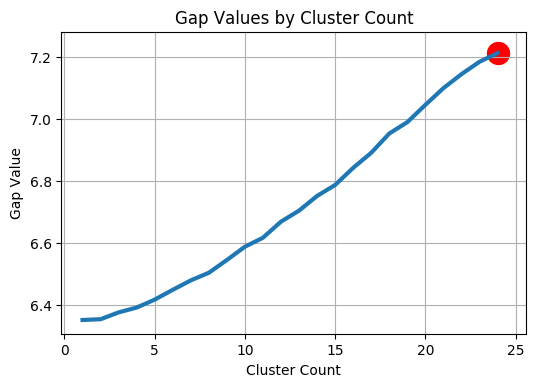

In [81]:
k, gapdf = optimalK(eigenvectors[:,1:], maxClusters=25)
print('Optimal K = {}'.format(k))
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [68]:
nb_clusters

array([7, 5, 1, 2, 4])

In [18]:
from graph_utils import get_laplacian
from scipy.linalg import eigh
L = get_laplacian(graph.toarray())
evals, evecs = eigh(L) 

In [24]:
np.argsort(np.diff(evals[:100]))[::-1][:5]+1

array([10, 44,  7,  5, 19])

In [62]:
from scipy.sparse import csgraph
from graph_utils import get_laplacian
L1 = csgraph.laplacian(graph)
L2 = get_laplacian(graph)
assert (L1 != L2).nnz==0

In [63]:
from scipy.sparse.linalg import eigsh
eval1, evec1 = eigsh(L2, which = 'SM', k=10)

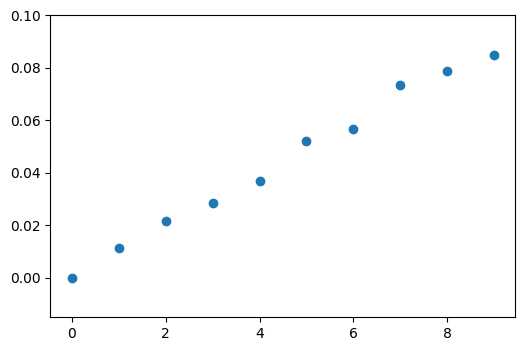

In [64]:
plt.scatter(np.arange(len(eval1)), eval1)

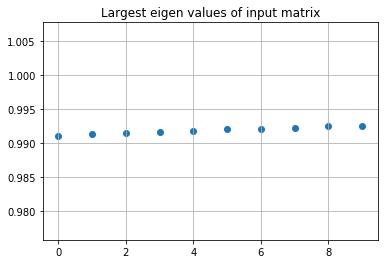

In [25]:
from main_methods import graph_eig_decomp
nb_clusters, eigenvalues, eigenvectors = graph_eig_decomp(graph)
plt.title('Largest eigen values of input matrix')
plt.scatter(np.arange(10), eigenvalues[:10])
plt.grid()

In [15]:
nb_clusters

array([24, 14, 18, 33,  8])

In [ ]:
plt.title('Largest eigen values of input matrix')
plt.scatter(np.arange(len(eigvals)), eigvals)
plt.grid()

In [ ]:
index_largest_gap = np.argsort(np.diff(eigvals))[::-1][:topK]

In [21]:
from main_methods import graph_eig_decomp
# check for symmetry
assert (graph != np.transpose(graph)).nnz==0
# nb_clusters, eigenvalues, eigenvectors = graph_eig_decomp(g.toarray())
print(nb_clusters)

[48 78 93 11 16]


In [50]:
np.transpose(g)

<6892x6892 sparse matrix of type '<class 'numpy.float64'>'
	with 118310 stored elements in Compressed Sparse Column format>

# Old embeddings

In [94]:
from main_methods import compute_all_embeddings
from intestine_info import load_gene_set_clusters
from main_methods import compute_embedding
from general_utils import norm_mtx
kmtx, kdf = load_gene_set_clusters(var_df)

embed_dict = compute_all_embeddings(result, c_mtx, mtx)
display(kdf.head())
moor = compute_embedding(kmtx)
ours = compute_embedding(c_mtx[kdf['orig_idx'], :])
naive = compute_embedding(mtx[:, kdf['orig_idx']].T)
naive['umap 1'] = -naive['umap 1']
ours['umap 2'] = -ours['umap 2']
embed_dict['trim_expression'] = naive
embed_dict['trim_moor'] = moor
embed_dict['trim_coefficient'] = ours
print(embed_dict.keys())

Computing embedding for: all_coefficient
input dimension: (9656, 5)
Computing embedding for: all_expression
input dimension: (9656, 1383)
Computing embedding for: rejected_coefficient
input dimension: (6892, 5)
Computing embedding for: rejected_expression
input dimension: (6892, 1383)


,indin,clust_idx,curr_idx,orig_idx
gene_name,,,,
Mrpl15,8,1,0,0
Lypla1,9,3,1,1
Arfgef1,40,3,2,14
Tram1,52,1,3,16
Rpl7,63,4,4,20


input dimension: (2118, 7)
input dimension: (2118, 5)
input dimension: (2118, 1383)
dict_keys(['all_coefficient', 'all_expression', 'rejected_coefficient', 'rejected_expression', 'trim_expression', 'trim_moor', 'trim_coefficient'])


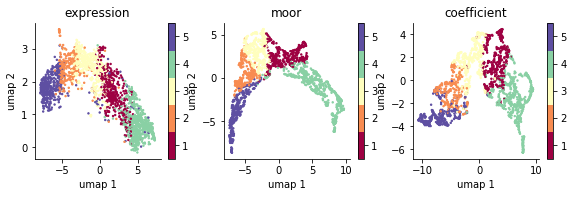

In [35]:
from plot_utils import plot_scatter_discrete
methods = ['expression', 'moor', 'coefficient']
var_labs = kdf['clust_idx']
fig, axes = plt.subplots(1, len(short_embed), figsize=(3.2*len(short_embed),2.5))
data_grp = 'trim'
for i, m in enumerate(methods):
    df = embed_dict['{}_{}'.format(data_grp, m)]
    ax = axes[i]
    plot_scatter_discrete(df[["umap 1", "umap 2"]].values, var_labs, ax=ax, ms=2)
    ax.set_title(m)
    ax.set_xlabel('umap 1')
    ax.set_ylabel('umap 2')
plt.show()

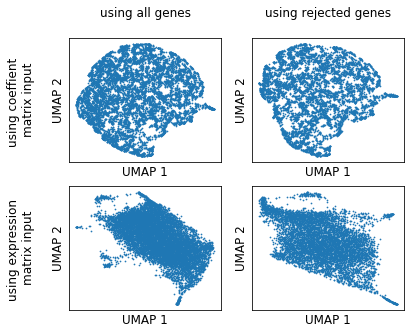

In [17]:
# plot the embeddings
fontsize = 12
sel_list = ["all", "rejected"]
mat_list = ["coeffient", "expression"]
fig, axes = plt.subplots(len(sel_list), len(mat_list), figsize=(3*len(mat_list), 2.5*len(sel_list)))
for i, sel in enumerate(sel_list):
    for j, mat in enumerate(mat_list):
        plt_df = embed_dict["{}_{}".format(sel, mat)]
        ax = axes[j, i]
        x = plt_df['umap 1']
        y = plt_df['umap 2']
        ax.scatter(x, y, s=0.5)
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_xlabel("UMAP 1", fontsize=fontsize)
        if j == 0:
            ax.set_title("using {} genes\n".format(sel), fontsize=fontsize)
        if i == 0:
            ax.set_ylabel("using {} \nmatrix input\n\nUMAP 2".format(mat), fontsize=fontsize)
        else:
            ax.set_ylabel("UMAP 2".format(mat), fontsize=fontsize)
plt.show()